# Figure X. Batch Size

Imports.

In [441]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import zipfile
import pandas as pd
from tqdm.auto import tqdm
from io import TextIOWrapper
from collections import defaultdict

Load from disk.

In [442]:
def get_records(path, measure):

    trial_indices = defaultdict(int)
    
    with zipfile.ZipFile(path, 'r') as z:
        for filename in tqdm(z.namelist()):
            if filename.endswith('.json'):
                with z.open(filename) as file:
                    with TextIOWrapper(file, encoding='utf-8') as text_file:
                        try:
                            result = json.load(text_file)
                            record = pd.DataFrame(
                                result['annotations']
                            ).reindex(
                                columns=[
                                    'ABL1 pIC50',
                                    'Log P',
                                    'Log S',
                                    'Step Made',
                                ]
                            ).dropna()

                            value = result[measure]
                            trial_indices[value] += 1
                            record[measure] = value
                            record['trial'] = trial_indices[value]
                            
                            records.append(record)
                            result = None
                        except:
                            continue
    return records

paths = [
    '../../dgym-data/analysis/batch_size/selection_batch_size_2024-05-11_21-08-39_continued.zip',
]

measure = 'batch_size'
records = []
for path in paths:
    records.extend(get_records(path, measure))

df_raw = pd.concat(records)
records = None

  0%|          | 0/800 [00:00<?, ?it/s]

Score using utility function.

In [443]:
from dgym.envs.utility import MultipleUtilityFunction, ClassicUtilityFunction

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    ideal=(9, 13),
    acceptable=(8, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    ideal=(-0.5, 3.5),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    ideal=(-4, 1),
    acceptable=(-4, 1)
)

composite_utility_function = MultipleUtilityFunction([
    docking_utility_function, log_P_utility_function, log_S_utility_function])

In [444]:
records = []
for (value, trial), data in tqdm(df_raw.groupby([measure, 'trial'])):
    utility = composite_utility_function(data.values, precompute=True, method='average')
    try:
        cost = utility.index(1.0)
        success = 1
    except:
        cost = len(utility)
        success = 0

    record = {
        measure: value,
        'trial': trial,
        'outcome': success,
        'cost': cost,
        'time': data['Step Made'].max()
    }
    records.append(record)

df = pd.DataFrame(records)

  0%|          | 0/800 [00:00<?, ?it/s]

Plotting adjusted outcomes.

In [450]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Determine the maximum cost to extend the eCDF
def get_ecdf(budget_type):
    
    max_cost = df[budget_type].max()
    timeline = np.linspace(0, max_cost, 500)

    ecdfs = []
    for idx, (value, group) \
        in enumerate(df.groupby(measure)):

        # Create Kaplan-Meier object
        kmf = KaplanMeierFitter()

        # Fit data
        kmf.fit(
            durations=group[budget_type],
            event_observed=group['outcome'],
            timeline=timeline,
            alpha=0.32
        )

        # add confidence intervals
        ecdf_ = pd.merge(
            kmf.cumulative_density_,
            right=kmf.confidence_interval_cumulative_density_,
            left_index=True,
            right_index=True
        ).reset_index()

        ecdf_[measure] = value
        ecdfs.append(ecdf_)

    ecdf = pd.concat(ecdfs)
    
    return ecdf

budget = 'cost'
ecdf = get_ecdf(budget)

Text(0.5, 1.0, 'Cumulative probability of success versus batch size')

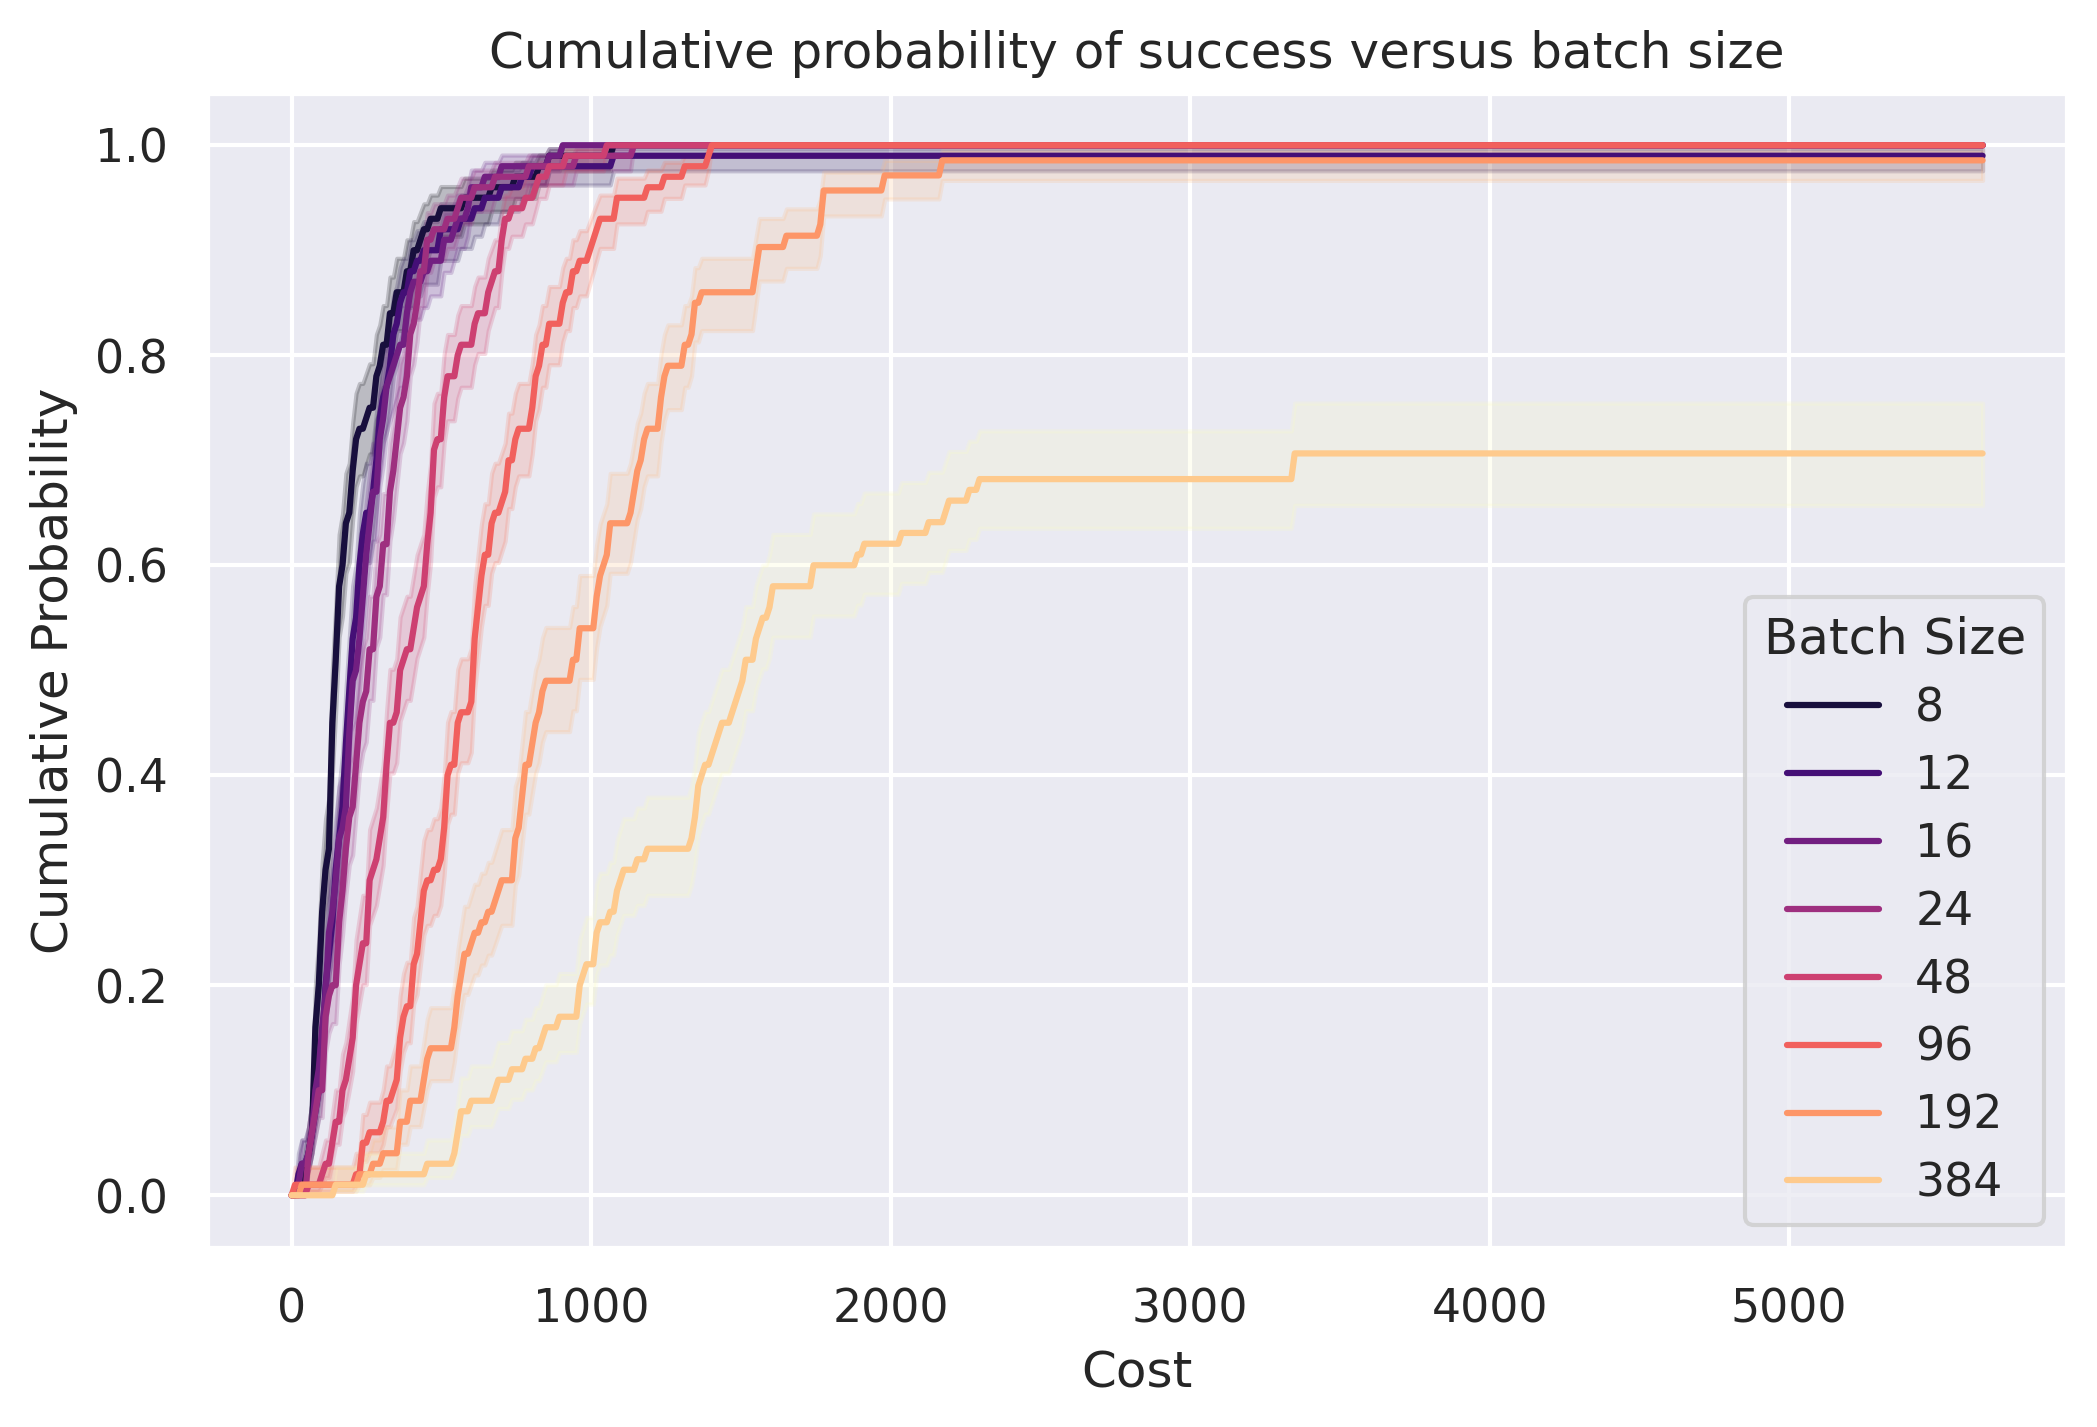

In [452]:
import seaborn as sns

plt.figure(figsize=(8, 5), dpi=300)

sns.set()
g = sns.lineplot(
    ecdf,
    x='timeline',
    y='KM_estimate',
    hue=measure,
    palette=sns.color_palette('magma', len(ecdf[measure].unique()))
)

colormap = sns.palettes.get_colormap('magma')
colors = colormap.resampled(len(ecdf.query(f'{measure} % {interval} == 0').groupby(measure)))

for idx, (name, group) in enumerate(ecdf.query(f'{measure} % {interval} == 0').groupby(measure)):
    g.fill_between(
        group['timeline'],
        group['KM_estimate_lower_0.68'],
        group['KM_estimate_upper_0.68'],
        alpha=0.2,
        color=colors.colors[idx]
    )

plt.legend(title='Batch Size')
plt.xlabel('Cost')
plt.ylabel('Cumulative Probability')
# plt.xlim(-1, 150)
plt.ylim(-0.05, 1.05)
plt.title('Cumulative probability of success versus batch size')

### Plot variable vs. outcome

Text(0.5, 1.0, 'Success rate versus batch size | Budget = 750 steps')

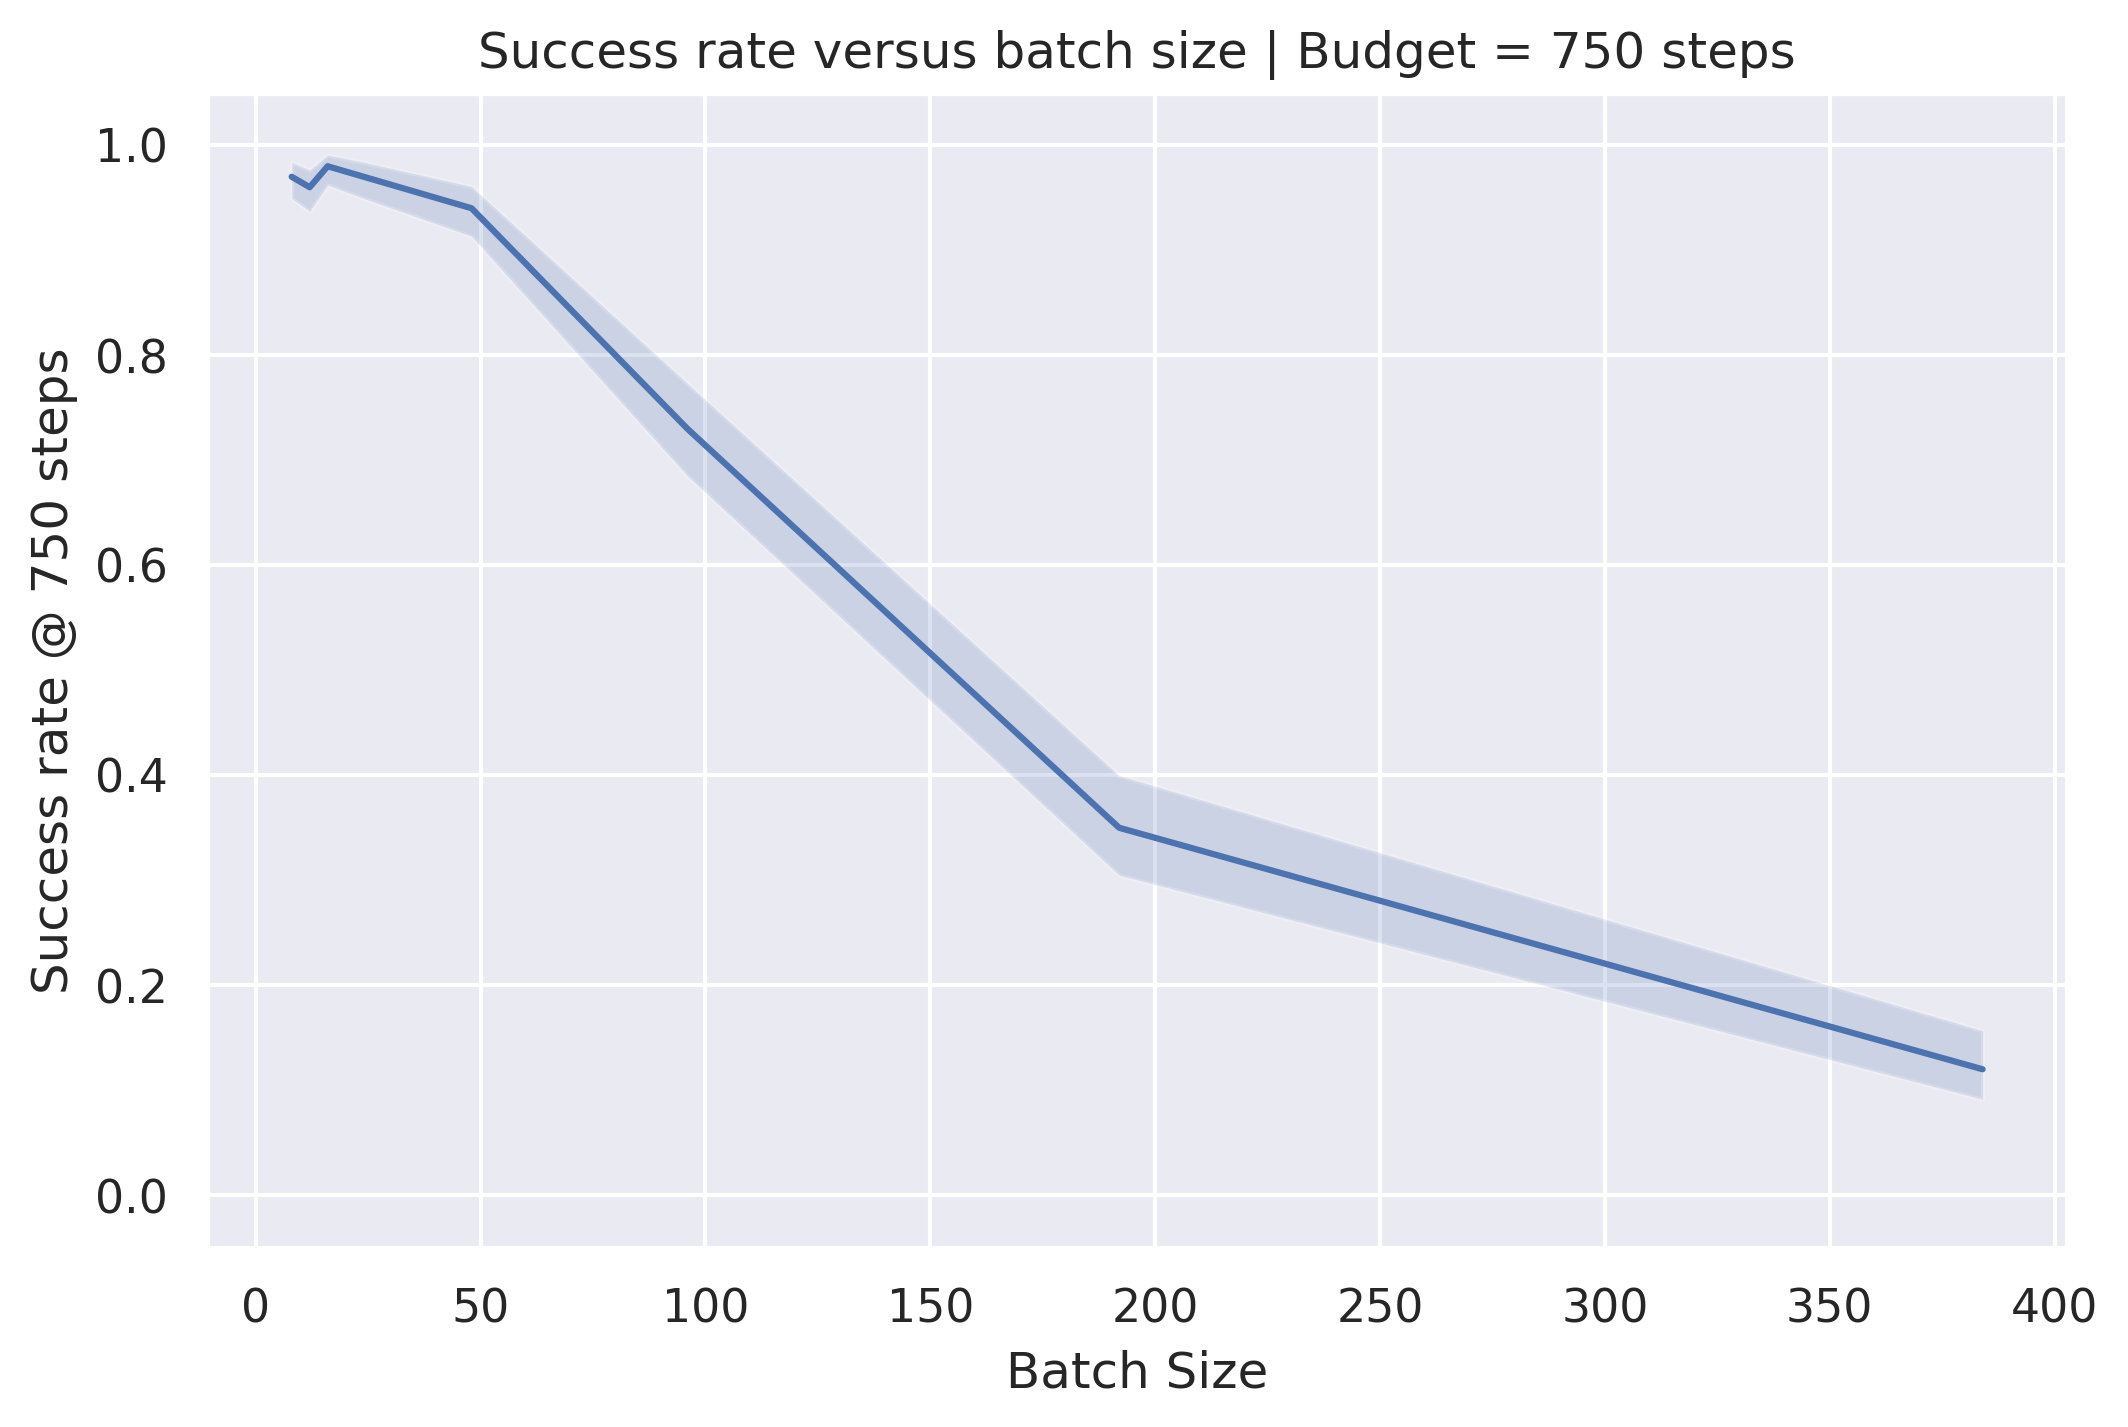

In [455]:
plt.figure(figsize=(8, 5), dpi=300)

budget = 750 # 10 for time elapsed
filtered = (
    ecdf
    .query(f'{budget} < timeline < {budget} + 10') # +10 molecules, +1 time
    # .query('batch_size not in [192, 384]') # necessary for time estimates
)

g = sns.lineplot(
    filtered,
    x='batch_size',
    y='KM_estimate',
    ci=False
)

g.fill_between(
    filtered['batch_size'],
    filtered['KM_estimate_lower_0.68'],
    filtered['KM_estimate_upper_0.68'],
    alpha=0.2,
)

plt.ylim(-0.05, 1.05)
plt.xlabel('Batch Size')
plt.ylabel(f'Success rate @ {budget} steps')
plt.title(f'Success rate versus batch size | Budget = {budget} steps')

## Minimum expected costs to achieve probability of success

Text(0, 0.5, 'Cost @ 80% Success Rate')

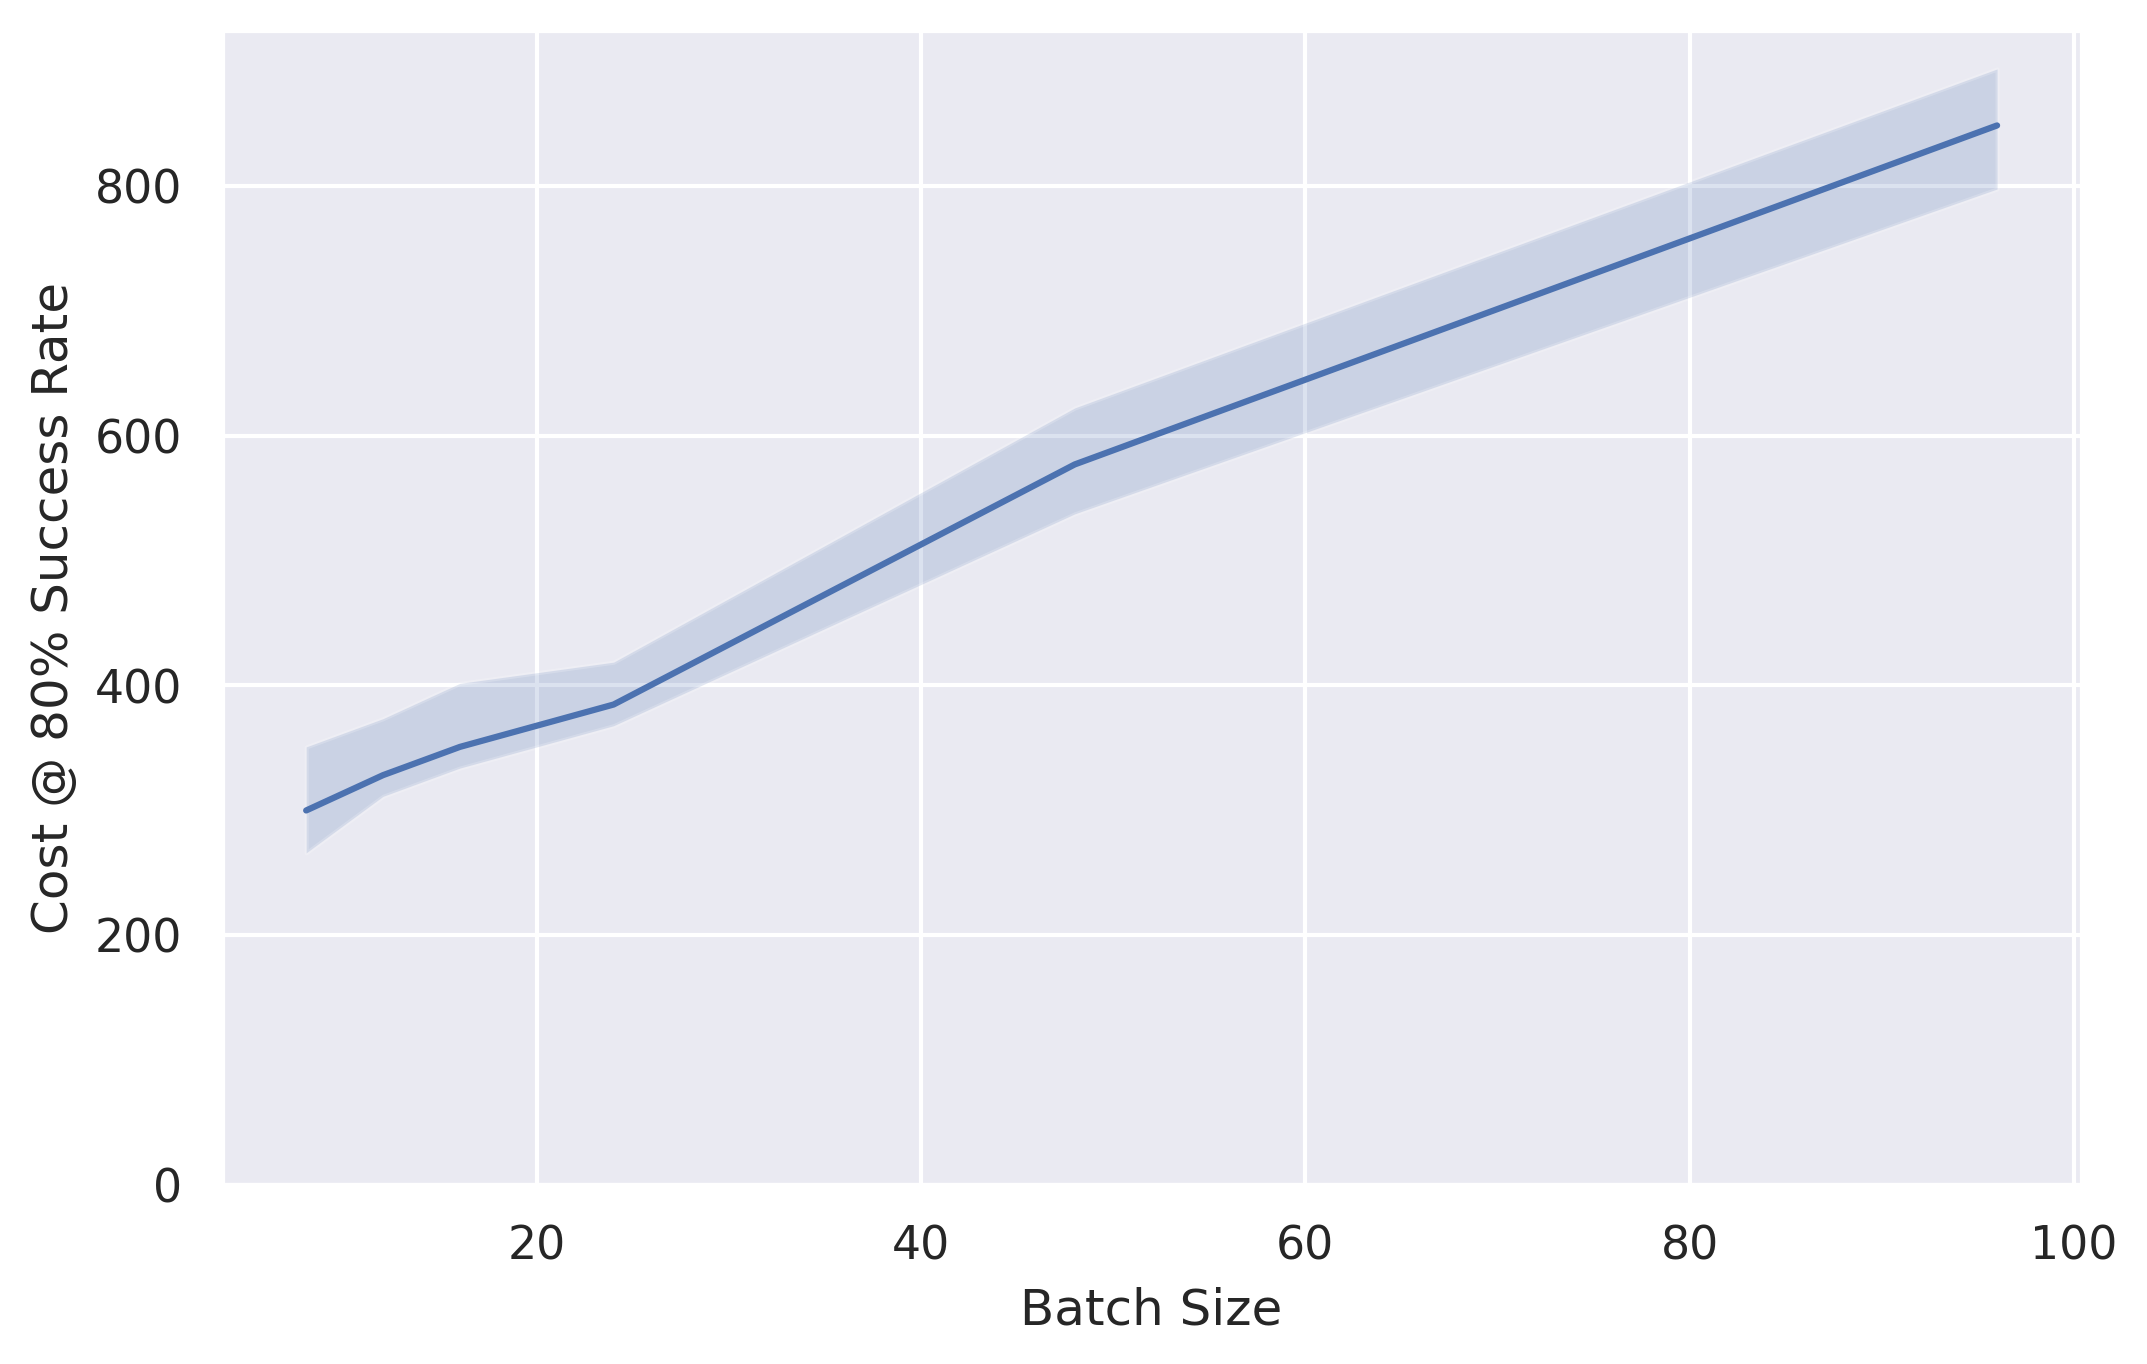

In [456]:
plt.figure(figsize=(8, 5), dpi=300)

prob_success = 0.8
subset = ecdf.query('batch_size not in [192, 384]')
filtered = subset.query(f'{prob_success} - 0.05 < KM_estimate < {prob_success} + 0.05')
filtered_low = subset.query(f'{prob_success} - 0.05 < `KM_estimate_lower_0.68` < {prob_success} + 0.05')
filtered_high = subset.query(f'{prob_success} - 0.05 < `KM_estimate_upper_0.68` < {prob_success} + 0.05')

filtered_mean = filtered.groupby('batch_size').agg({'timeline': 'mean'})
filtered_low = filtered_low.groupby('batch_size').agg({'timeline': 'mean'})
filtered_high = filtered_high.groupby('batch_size').agg({'timeline': 'mean'})

g = sns.lineplot(
    filtered_mean,
    x='batch_size',
    y='timeline',
)

max_ci_length = min(len(filtered_mean), len(filtered_low), len(filtered_high))
g.fill_between(
    filtered_mean.index[:max_ci_length],
    filtered_low['timeline'].iloc[:max_ci_length],
    filtered_high['timeline'].iloc[:max_ci_length],
    alpha=0.2,
)

plt.ylim(0)
plt.xlabel('Batch Size')
plt.ylabel(f'Cost @ {round(prob_success * 100)}% Success Rate')
# plt.title(f'Expected cost versus temperature | Probability of Success = {prob_success * 100}%')

Analyze tradeoff.

Text(0.5, 1.0, 'Tradeoff of time and cost across batch sizes')

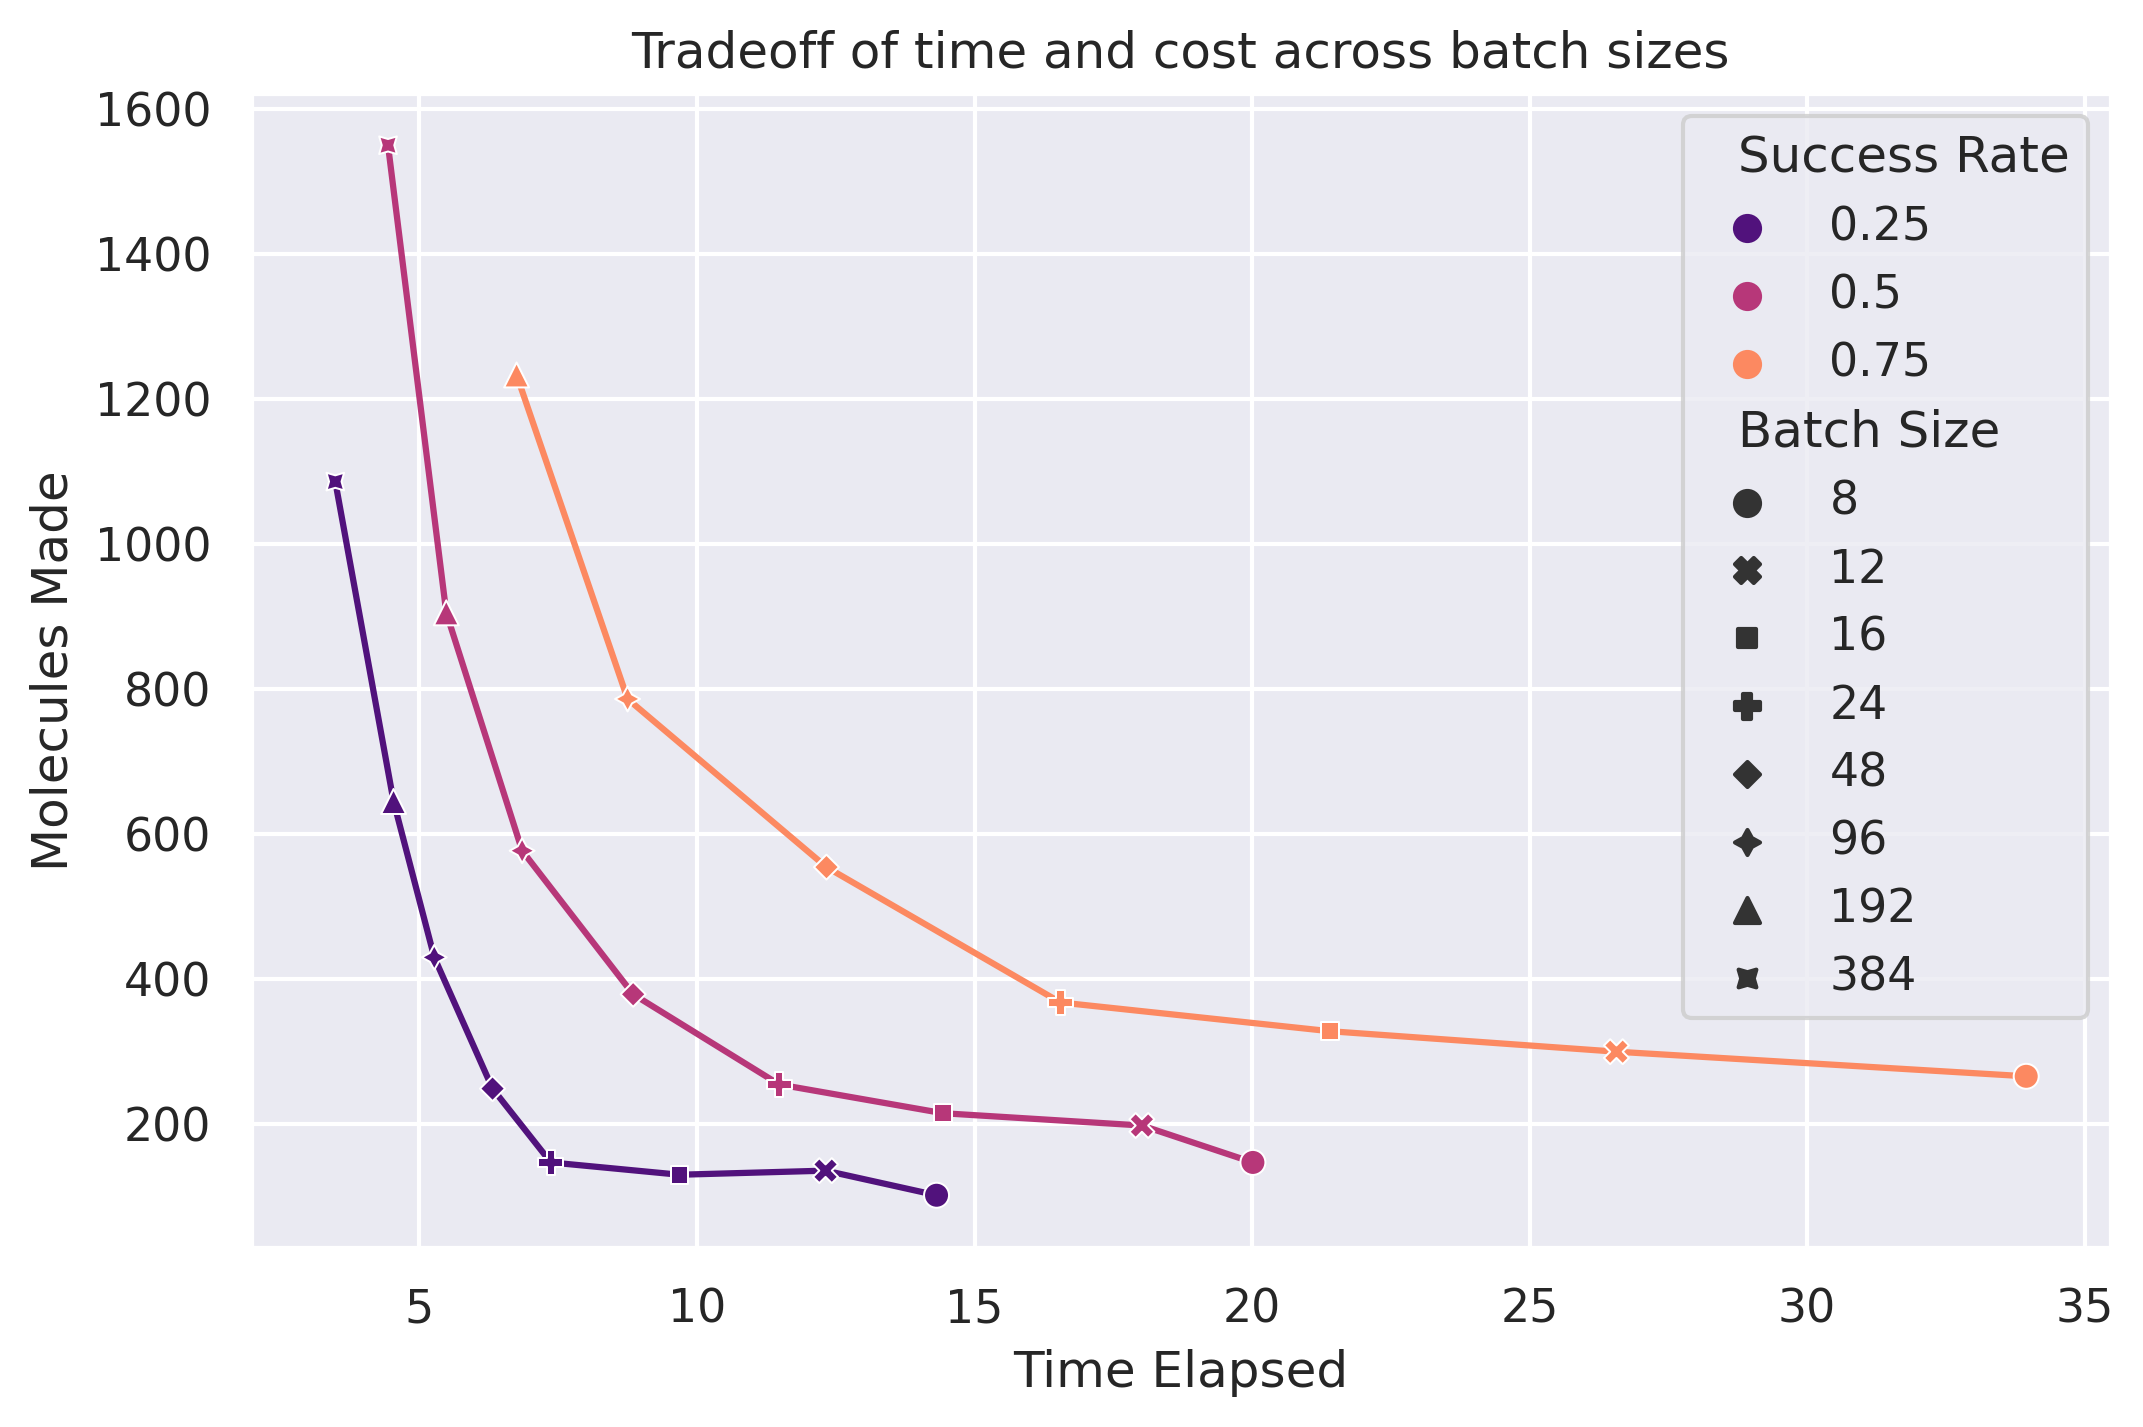

In [459]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

ecdf_cost = get_ecdf('cost')
ecdf_time = get_ecdf('time')

combined = []
for prob_success in [0.25, 0.5, 0.75]:
    filtered_cost = ecdf_cost.query(f'{prob_success} - 0.1 < KM_estimate < {prob_success} + 0.1')
    filtered_time = ecdf_time.query(f'{prob_success} - 0.1 < KM_estimate < {prob_success} + 0.1')
    cost_mean = filtered_cost.groupby('batch_size').agg('mean')
    time_mean = filtered_time.groupby('batch_size').agg('mean')
    cost_mean = cost_mean.reindex(['timeline'], axis=1).rename(columns={'timeline': 'cost'})
    time_mean = time_mean.reindex(['timeline'], axis=1).rename(columns={'timeline': 'time'})
    combined_ = time_mean.merge(cost_mean, left_index=True, right_index=True)
    combined_['Success Rate'] = prob_success
    combined.append(combined_)

combined = pd.concat(combined)
combined.index = combined.index.rename('Batch Size')

# ensure no overlapping times
for idx, batch_size in enumerate(combined.index.unique()[::-1]):
    combined.loc[batch_size, 'time'] += (idx * 0.1)

colors = sns.color_palette('magma', len(combined['Success Rate'].unique()))
g = sns.lineplot(
    combined,
    x='time',
    y='cost',
    hue='Success Rate',
    palette=colors,
    ax=ax,
    legend=False,
)

g = sns.scatterplot(
    combined,
    x='time',
    y='cost',
    hue='Success Rate',
    marker="o",
    palette=colors,
    style='Batch Size',
    ax=ax,
    zorder=5,
)
    
# g.legend(title='Success Rate')
plt.xlabel('Time Elapsed')
plt.ylabel('Molecules Made')
plt.title('Tradeoff of time and cost across batch sizes')